In [1]:
import os
import json
import numpy as np
import pickle 
import tqdm
import tarfile
from scipy import sparse
from collections import defaultdict
from pprint import pprint
from collections import Counter

In [2]:
def load_data(path):
    with open(path, 'rb') as fp:
        data = pickle.load(fp)

    return data["xs"], data["ys"]

def load_weights_dict(path):
    with open(path, 'rb') as fp:
        weights_dict = pickle.load(fp)
    return weights_dict

def get_dummy_classifier():
    return DummyClassifier(strategy="constant", constant=0)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier


# output_path = "../data/dataset_positions_winners.pkl" 
output_path = "../data/dataset_positions_all.pkl" 

weights_path = "../data/weights_dict.pkl"
xs, ys = load_data(output_path)
weights_dict = load_weights_dict(weights_path)

clfs = {}
scores = {}
scores_dict = {}
n_features = np.vstack(xs[1]).shape[1]
for hid in tqdm.tqdm(xs):
    try:
        x = np.vstack(xs[hid])
        y = np.hstack(ys[hid])
        
        class_weight = {e:v for e, v in enumerate(weights_dict[hid])}
        unique = np.unique(np.hstack(ys[hid]))

        for class_role in [1, 2, 3, 4, 5]:
            if not class_role in unique.tolist():
                print('added classrole', class_role, "for hero", hid)
                xs[hid].append(np.zeros((n_features)))
                ys[hid].append(class_role)

        x = np.vstack(xs[hid])
        y = np.hstack(ys[hid]) - 1

        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

        clf = LogisticRegression(multi_class="ovr", max_iter=300, n_jobs=-1, solver="lbfgs", class_weight=class_weight)
        clf.fit(x_train, y_train)

        score = clf.score(x_test, y_test)
        clfs[hid] = clf
        scores[hid] = score
        scores_dict[hid] = score


    except:
        print("creashed on hid: ", hid)
        raise


100%|██████████| 121/121 [01:29<00:00,  1.36it/s]


In [4]:
from sklearn.metrics import confusion_matrix
hid = 129
print(confusion_matrix(clfs[hid].predict(np.vstack(xs[hid])), np.hstack(ys[hid])-1))

counts, unique = np.unique(np.hstack(ys[hid])-1, return_counts=True)
print(counts, unique)

[[   0    0    0    0    0]
 [   0    0    0    0    0]
 [  67  267 4162  470   67]
 [   0    1    3  124   51]
 [   0    0    0    0    2]]
[0 1 2 3 4] [  67  268 4165  594  120]


[0 1 2 3 4] [1708  114 1632  365  417]

In [5]:
from sklearn.metrics import classification_report
print(classification_report(clfs[hid].predict(np.vstack(xs[hid])), np.hstack(ys[hid])-1))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       1.00      0.83      0.90      5033
           3       0.21      0.69      0.32       179
           4       0.02      1.00      0.03         2

    accuracy                           0.82      5214
   macro avg       0.24      0.50      0.25      5214
weighted avg       0.97      0.82      0.88      5214



/home/bao/anaconda3/envs/dota/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bao/anaconda3/envs/dota/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/bao/anaconda3/envs/dota/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [7]:
with open("../data/heroes.json", "r") as fp:
    heroes = json.load(fp)

a = list(scores_dict.items())
a.sort(key=lambda x: x[1], reverse=False)

hid_to_name = {x["id"]:x["localized_name"] for x in heroes}
s_sum = []
for k, v in a:
    s_sum.append(v)
    print(hid_to_name[k], k, v)

np.mean(s_sum), np.median(s_sum)

Lone Druid 80 0.4537037037037037
Alchemist 73 0.4539877300613497
Visage 92 0.5040650406504065
Techies 105 0.5051020408163265
Broodmother 61 0.5087719298245614
Enchantress 58 0.5391304347826087
Vengeful Spirit 20 0.5415959252971138
Keeper of the Light 90 0.5470085470085471
Undying 85 0.5633333333333334
Rubick 86 0.5716451857467779
Razor 15 0.5753968253968254
Treant Protector 83 0.5789473684210527
Nature's Prophet 53 0.5793103448275863
Bloodseeker 4 0.5800604229607251
Dragon Knight 49 0.5911458333333334
Pugna 45 0.5946969696969697
Chen 66 0.5964912280701754
Venomancer 40 0.5995975855130785
Clinkz 56 0.6038251366120219
Dark Willow 119 0.6089828269484808
Skywrath Mage 101 0.615
Omniknight 57 0.6206896551724138
Shadow Demon 79 0.6211453744493393
Riki 32 0.6211699164345403
Winter Wyvern 112 0.6259314456035767
Silencer 75 0.6273666092943201
Hoodwink 123 0.6327077747989276
Ogre Magi 84 0.6338215712383488
Elder Titan 103 0.6358695652173914
Snapfire 128 0.6378504672897196
Pudge 14 0.640159045725

(0.7264247039389591, 0.7281795511221946)

In [23]:
ys_flat = np.concatenate([y for y in ys.values()]).ravel()
ys_flat.shape


(402510,)

[1 2 3 4 5] [80502 80502 80502 80502 80502]


<AxesSubplot:ylabel='Frequency'>

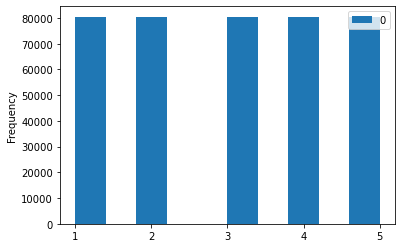

In [24]:
unique, counts = np.unique(ys_flat, return_counts=True)
print(unique, counts)
import pandas as pd

df = pd.DataFrame(ys_flat)
df.plot.hist(xticks=[1, 2, 3, 4, 5])
